# Adam Trentowski - 162602 - Machine Learning
## lab_08
## Library Imports

In [43]:
import numpy as np
import pandas as pd
import shap
import os

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree
from xgboost import XGBClassifier, plot_importance, to_graphviz

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import warnings
warnings.filterwarnings('ignore')

from eli5 import explain_weights, show_weights
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

In [2]:
CV_N_REPEATS = 5
BINS = 10

## Data loading

In [3]:
df = pd.read_csv('Tourists_lakes_Nature.csv')
df.head()

,Area,Mean depth,Shorline lenght,Coast development index,Lake elongation index,Shorline overgrowth degree,Vegeation coverage of lake,Forests around the coasline,Tourism
0,43.3,3.7,2896,1.19,2.009346,60,3,13.987108,1
1,48.7,6.1,3293,1.33,1.916667,51,12,53.262759,1
2,167.8,6.9,7228,1.55,2.342995,60,20,52.702899,1
3,89.6,6.0,10085,2.83,7.777778,35,7,75.000000,0
4,81.2,4.5,4391,1.38,2.093750,49,8,68.805422,1


In [5]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (145, 9)


## Elementary data analysis

Text(0, 0.5, 'Tourism')

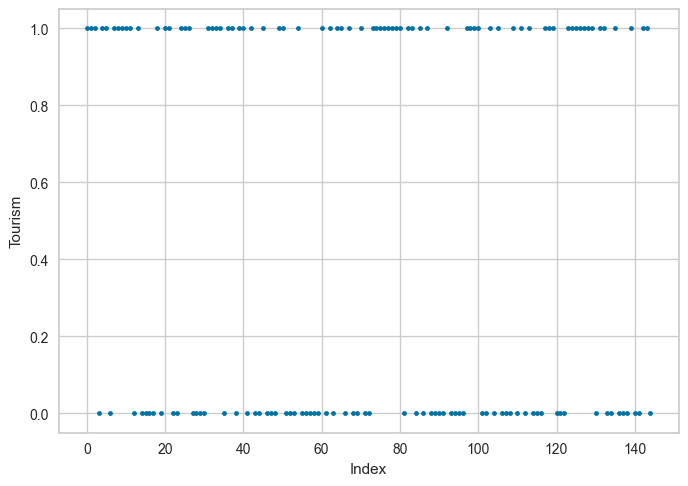

In [7]:
plt.figure()
plt.plot(df.Tourism, '.')
plt.xlabel('Index')
plt.ylabel('Tourism')

Text(0.5, 1.0, 'Seaborn countplot of Tourism within the dataset')

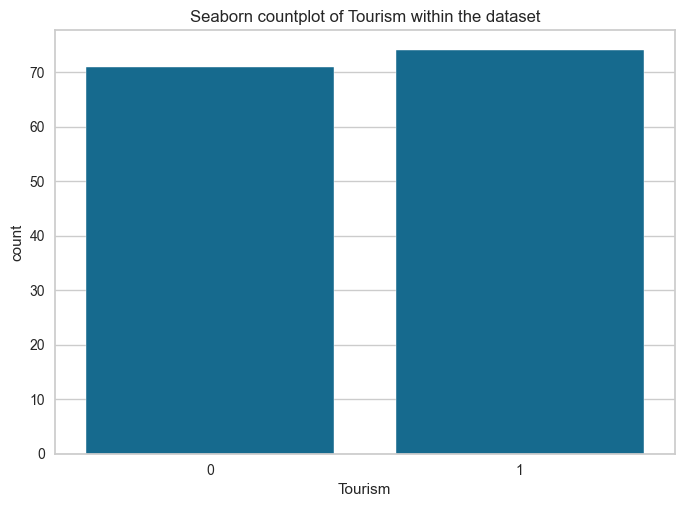

In [8]:
plt.figure()
ax = sns.countplot(data=df, x='Tourism')
ax.set_title("Seaborn countplot of Tourism within the dataset")

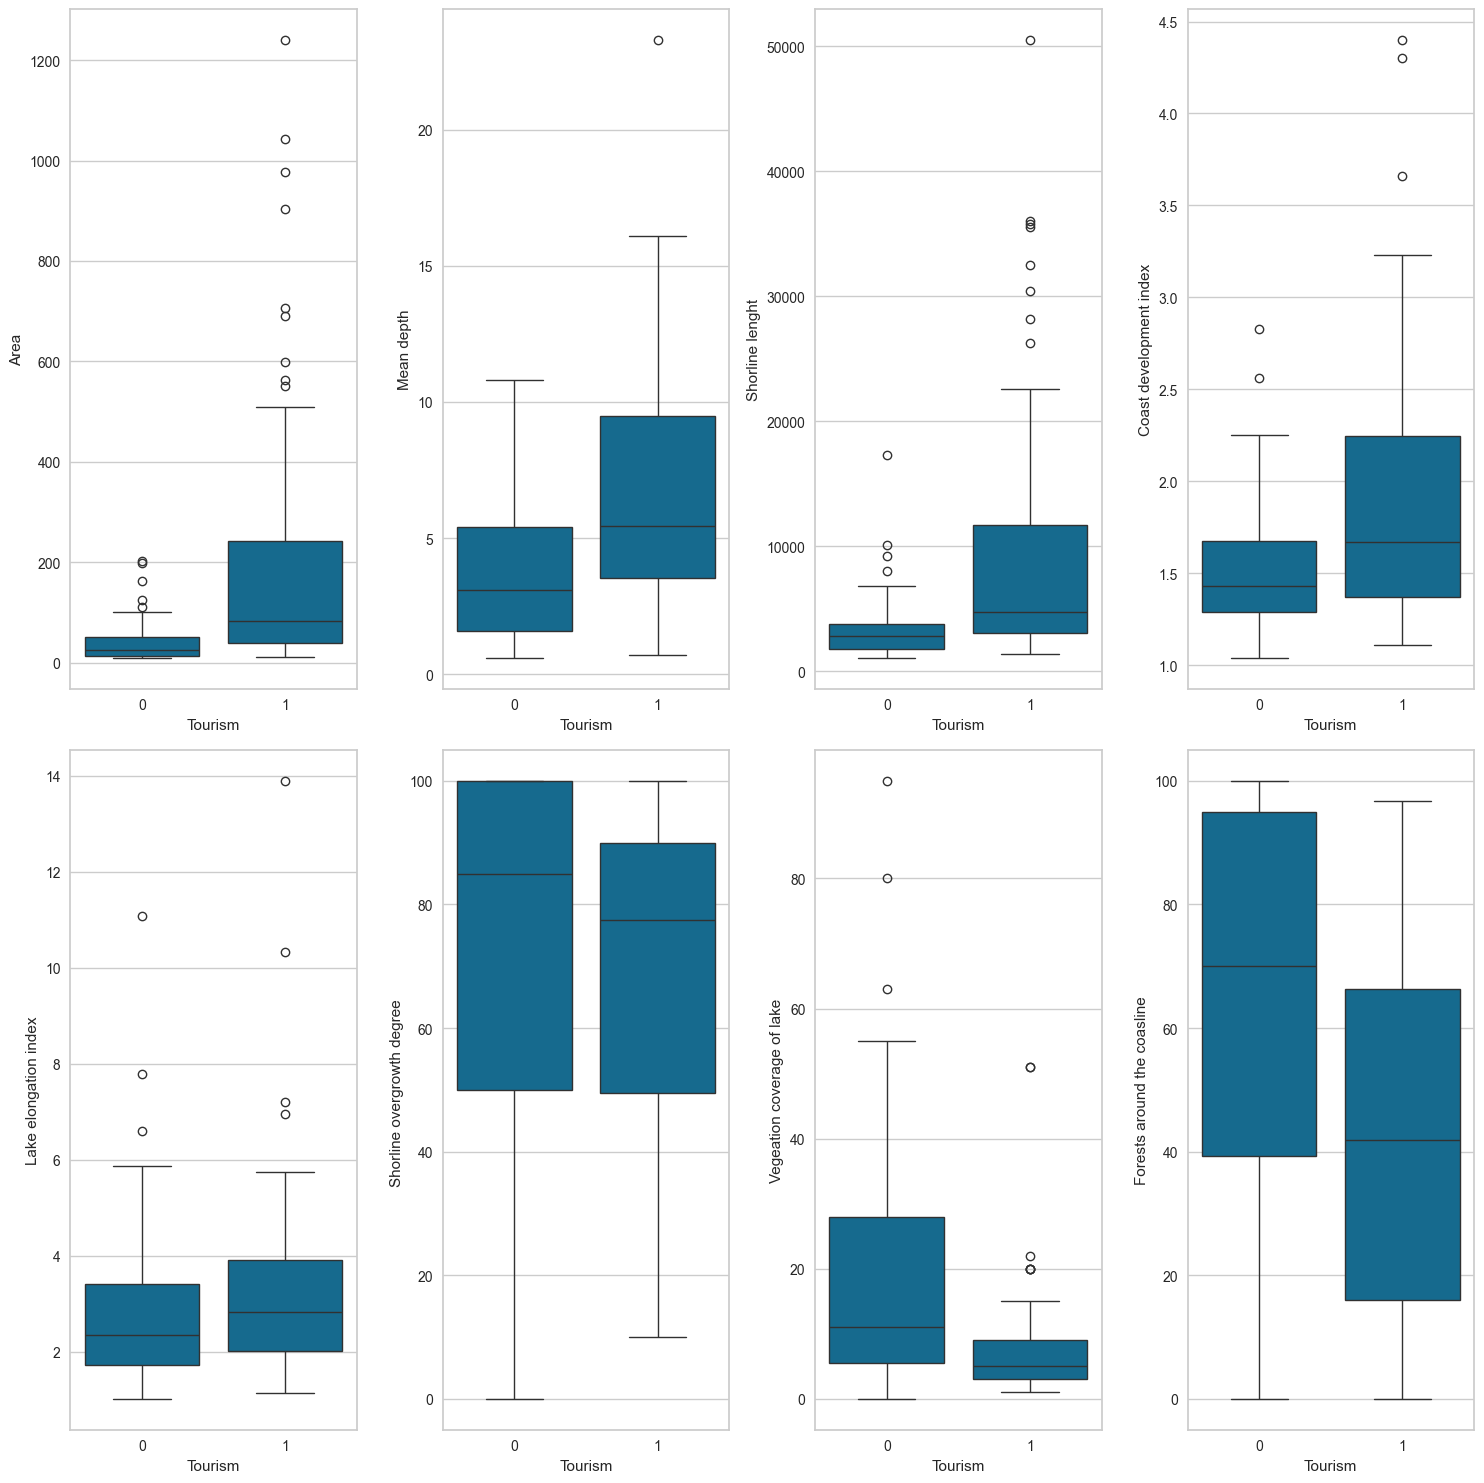

In [10]:
f, axes = plt.subplots(2, 4, figsize=(15, 15))
sns.set(style="white", palette="Set3", color_codes=True)

sns.boxplot(y="Area", x="Tourism", data=df, orient='v', ax=axes[0, 0])
sns.boxplot(y="Mean depth", x="Tourism", data=df, orient='v', ax=axes[0, 1])
sns.boxplot(y="Shorline lenght", x="Tourism", data=df, orient='v', ax=axes[0, 2])
sns.boxplot(y="Coast development index", x="Tourism", data=df, orient='v', ax=axes[0, 3])
sns.boxplot(y="Lake elongation index", x="Tourism", data=df, orient='v', ax=axes[1, 0])
sns.boxplot(y="Shorline overgrowth degree ", x="Tourism", data=df, orient='v', ax=axes[1, 1])
sns.boxplot(y="Vegeation coverage of lake", x="Tourism", data=df, orient='v', ax=axes[1, 2])
sns.boxplot(y="Forests around the coasline", x="Tourism", data=df, orient='v', ax=axes[1, 3])

f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                  hspace=0.4, wspace=0.3)
plt.tight_layout()

In [11]:
df_copy = df.copy(deep=True)
df_copy[['Area', 'Mean depth', 'Shorline lenght', 'Coast development index',
       'Lake elongation index', 'Shorline overgrowth degree ',
       'Vegeation coverage of lake', 'Forests around the coasline']] = df_copy[['Area', 'Mean depth', 'Shorline lenght', 'Coast development index',
       'Lake elongation index', 'Shorline overgrowth degree ',
       'Vegeation coverage of lake', 'Forests around the coasline']]
print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

Area                           0
Mean depth                     0
Shorline lenght                0
Coast development index        0
Lake elongation index          0
Shorline overgrowth degree     0
Vegeation coverage of lake     0
Forests around the coasline    0
Tourism                        0
dtype: int64


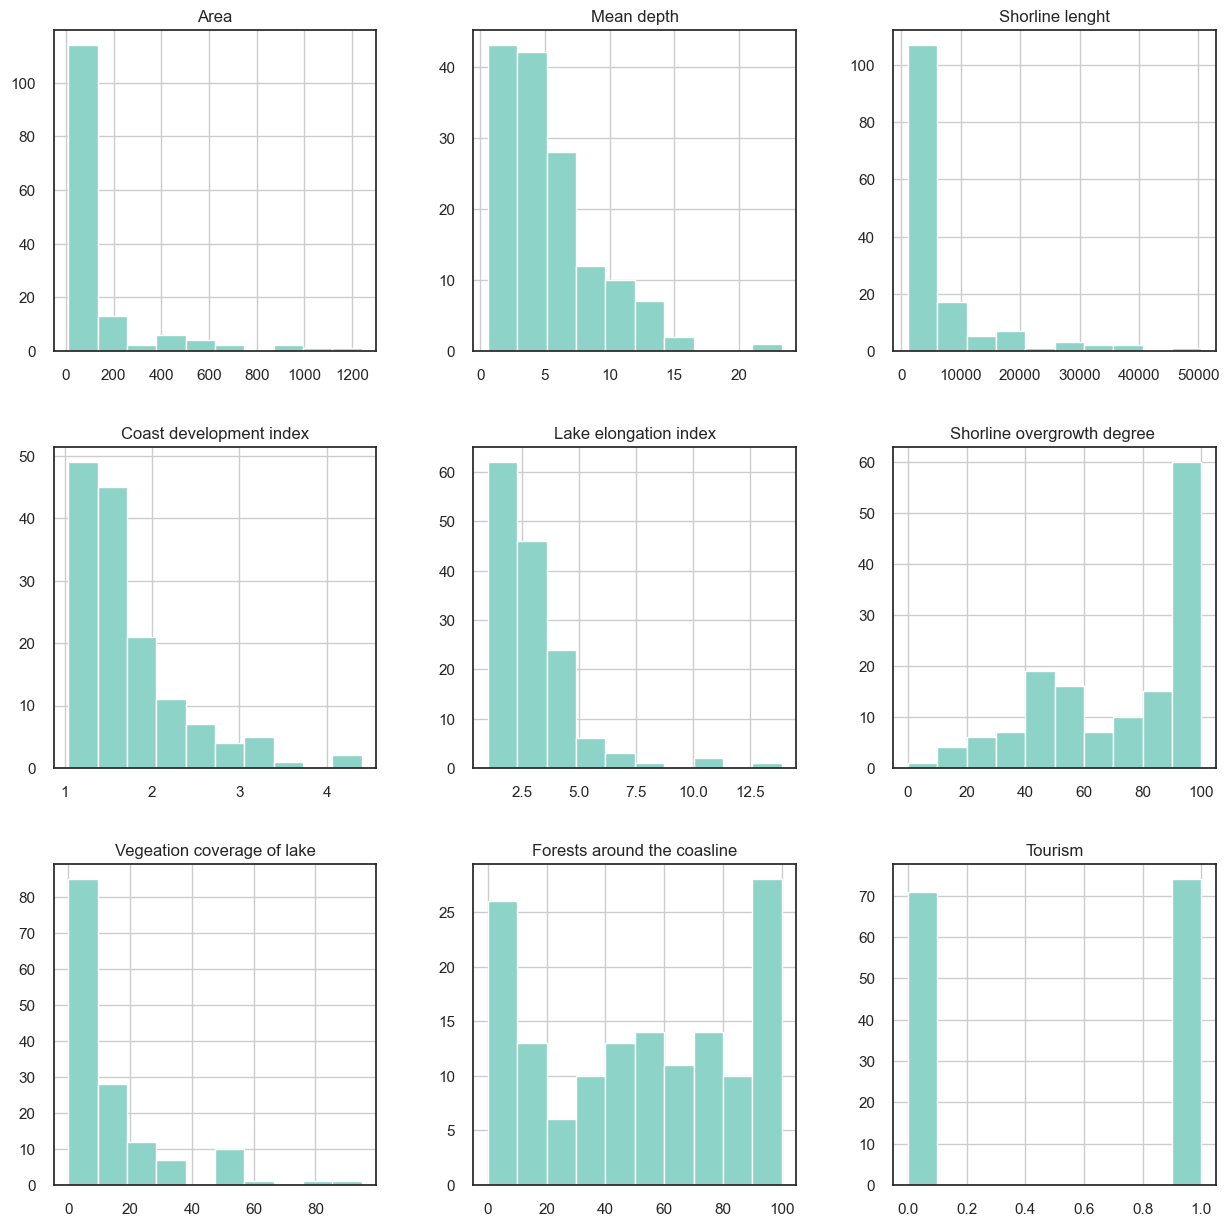

In [12]:
p = df.hist(figsize=(15, 15))

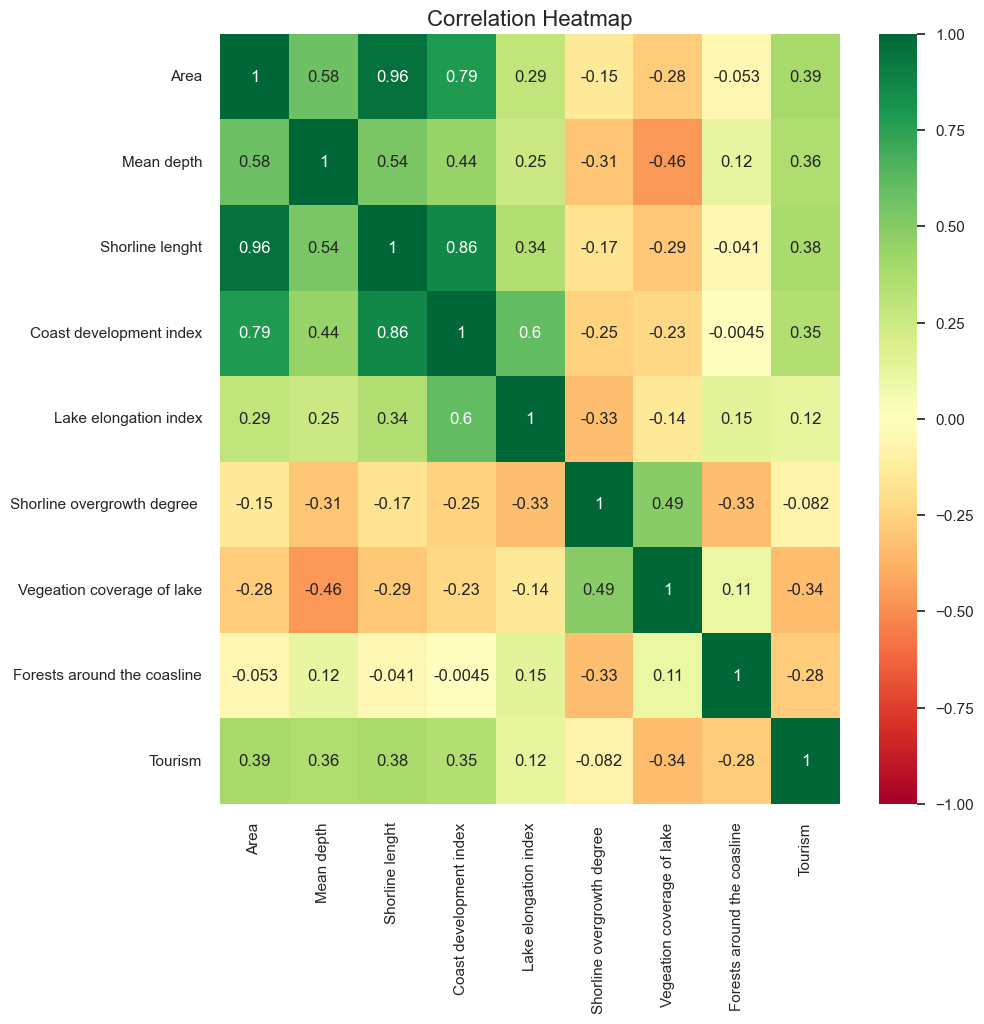

In [13]:
plt.figure(figsize=(10, 10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

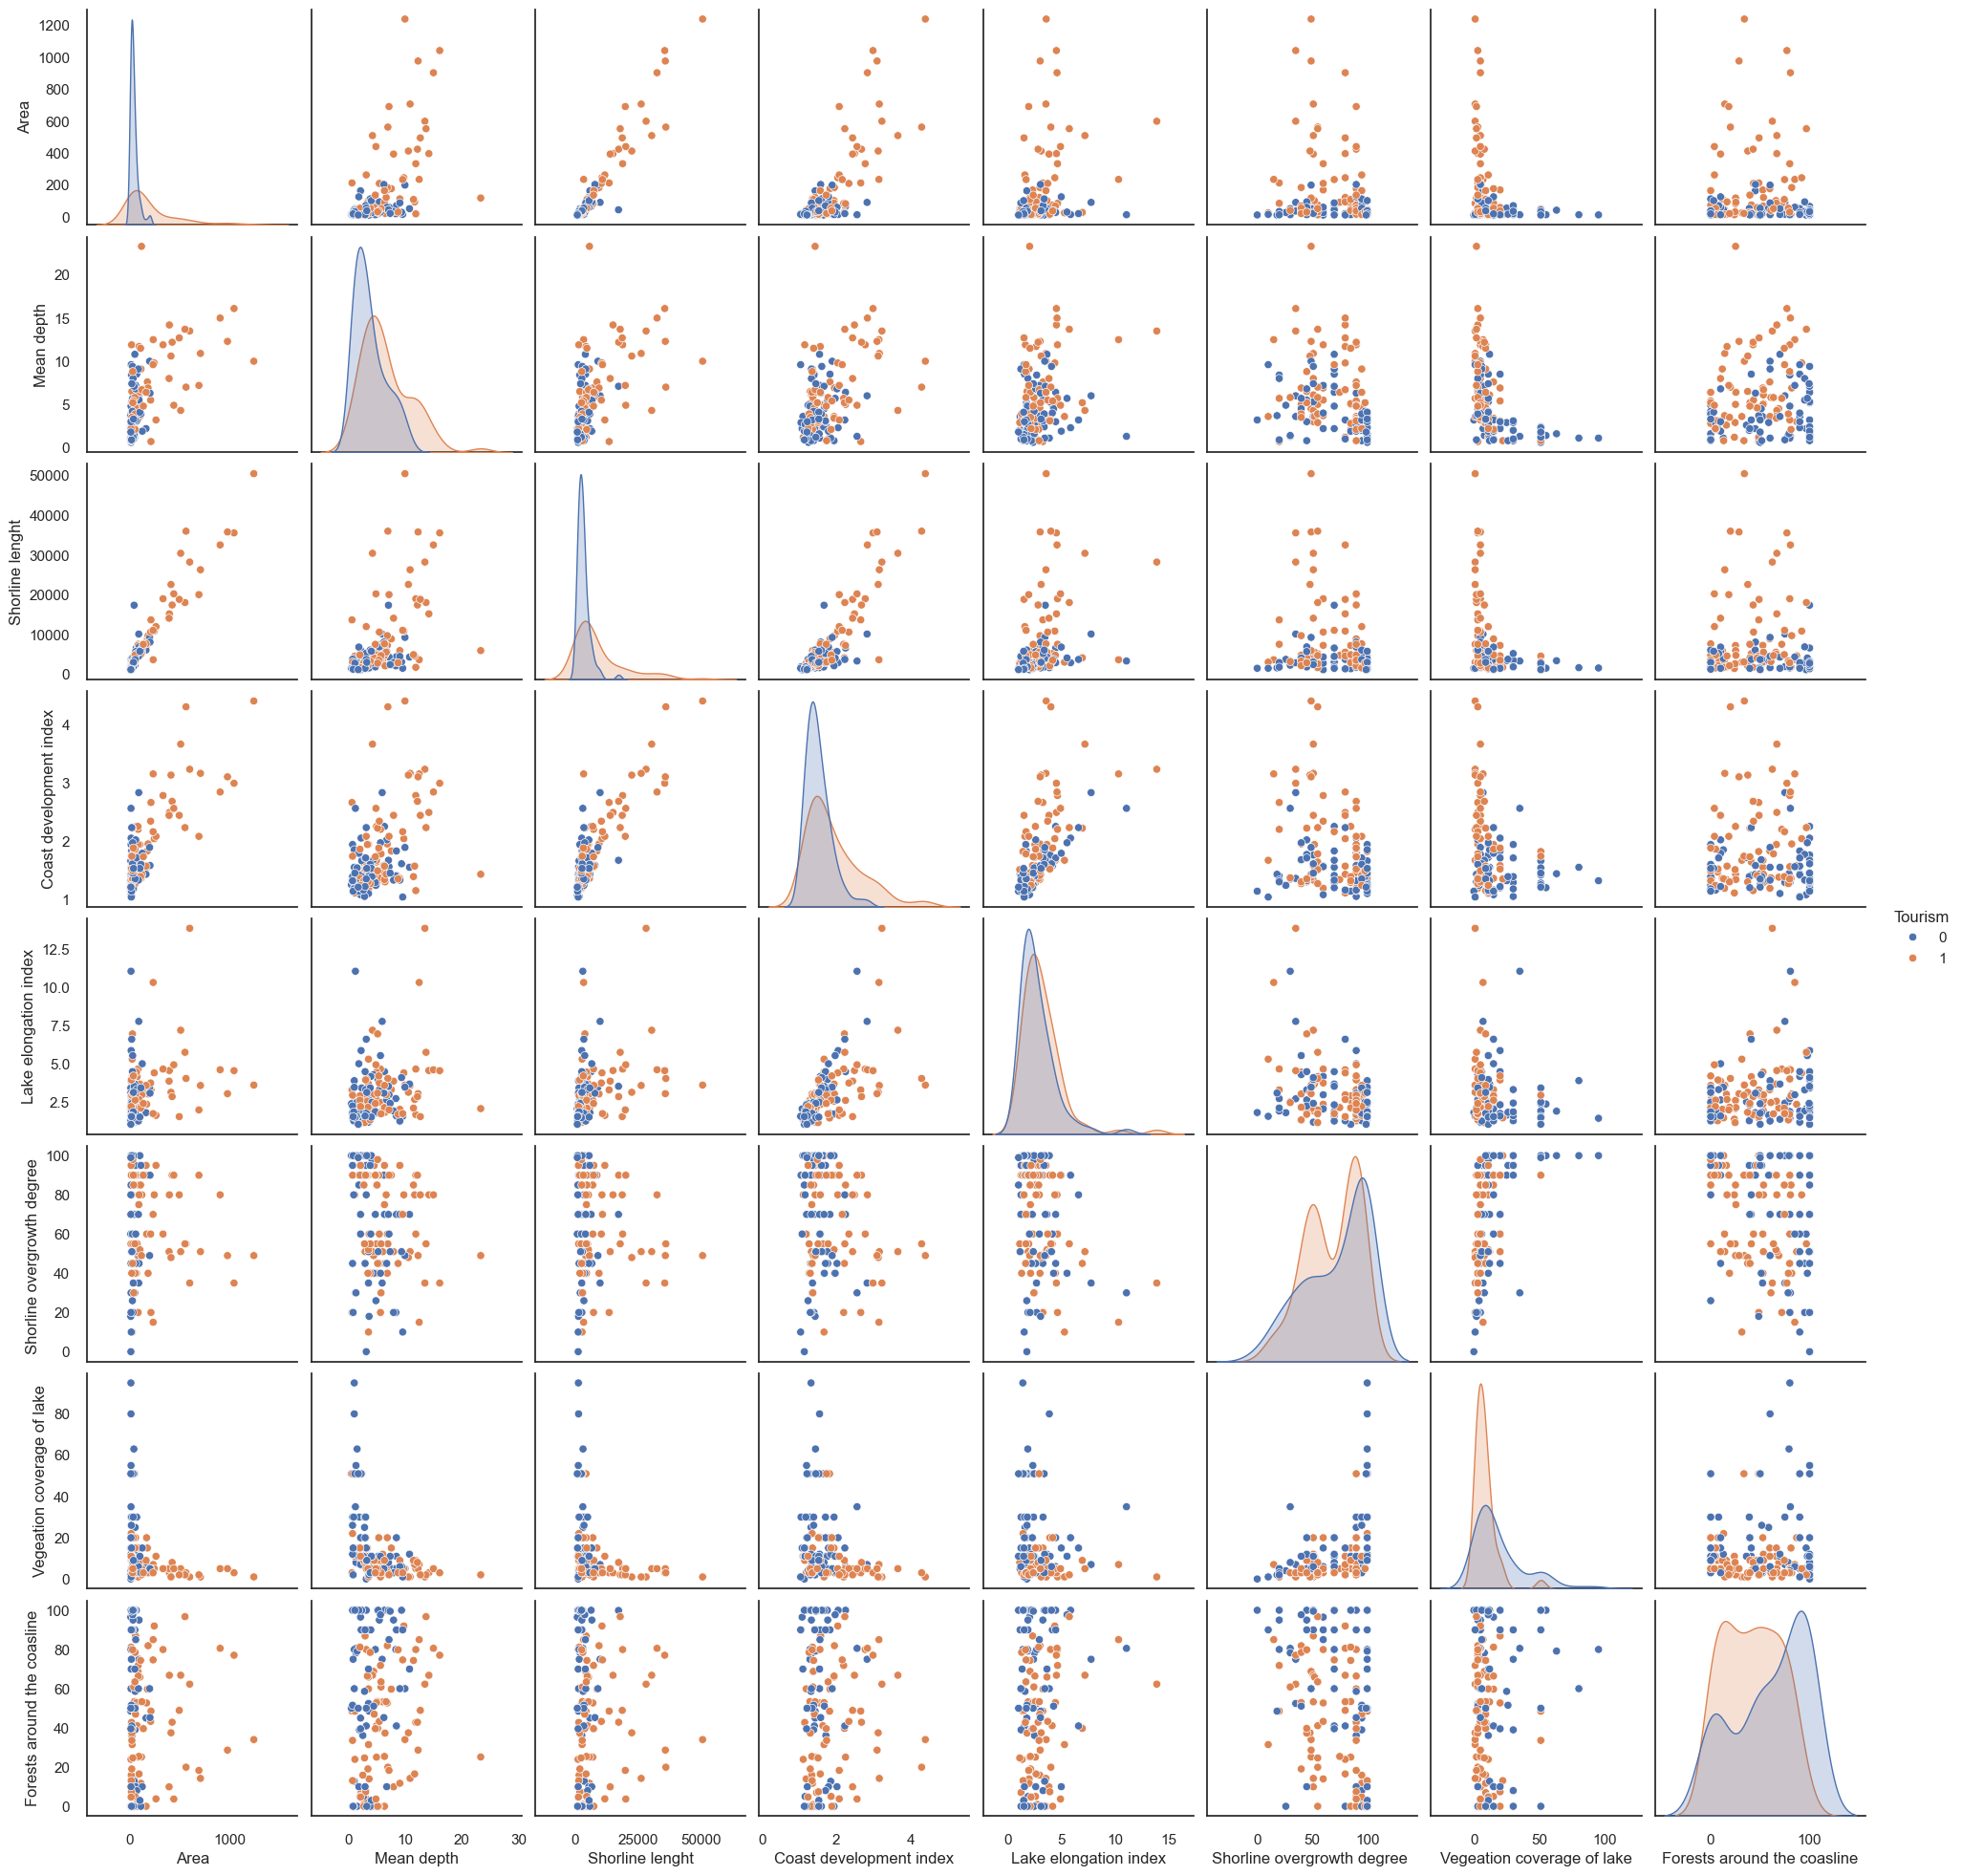

In [14]:
plt.figure()
sns.pairplot(data=df_copy, hue='Tourism', diag_kind='kde', palette='deep')

## Data splitting

In [18]:
X = df_copy.iloc[:, :-1]
Y = df_copy.iloc[:, -1]

seed = 7
test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (101, 8)
Shape of X_test: (44, 8)


## Model Building
### Dummy Classifier

In [16]:
dum = DummyClassifier(strategy='most_frequent')
dum.fit(X_train, y_train)
score = dum.score(X_test, y_test)
print("Dummy Classifier Accuracy: %.2f%%" % (score * 100.0))

Dummy Classifier Accuracy: 45.45%


Text(0, 0.5, 'Frequency')

<Figure size 700x700 with 0 Axes>

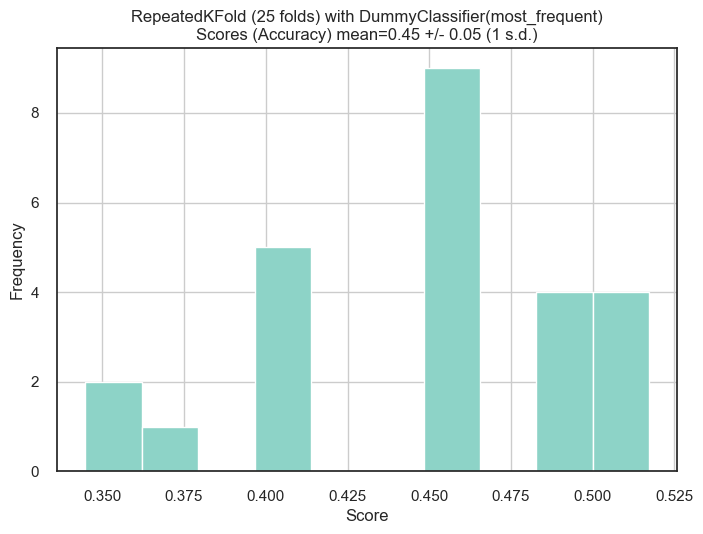

In [17]:
strategy = "most_frequent"
scores = cross_val_score(dum, X, Y,
                         cv=RepeatedKFold(n_repeats=CV_N_REPEATS),
                         scoring=None)

scores_dummy = scores.copy()

score_line = "Scores (Accuracy) mean={0:.2f} +/- {1:.2f} (1 s.d.)".format(scores.mean(), scores.std())
plt.figure(figsize=(7, 7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")

## Helper functions for graphical plotting of decision trees and to plot confusion matrix

In [19]:
def plot_tree_graph(model, columns, class_names):
    dot_data = export_graphviz(model, feature_names=columns, class_names=class_names)
    graph = graphviz.Source(dot_data)
    return graph

In [20]:
def confusion_mat(y_pred, y_test):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

### Decision tree

In [21]:
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)")

Accuracy mean=0.68 +/- 0.07 (1 s.d.)


### Bagging classifier

In [22]:
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag.fit(X_train, y_train)

bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print("Accuracy mean={0:0.2f} +/- {1:0.2f} (1 s.d.)".format(bag_scores.mean(), bag_scores.std()))
print("Out of bag score: {0:0.2f}".format(bag.oob_score_ * 100))

Accuracy mean=0.67 +/- 0.08 (1 s.d.)
Out of bag score: 63.37


### Random forest

In [23]:
num_estimators = 100
rf = RandomForestClassifier(n_estimators=num_estimators)
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier: {0:0.2f}".format(rf_score * 100.0))

Accuracy of Random Forest Classifier: 72.73


#### Make predictions and plot confusion matrix

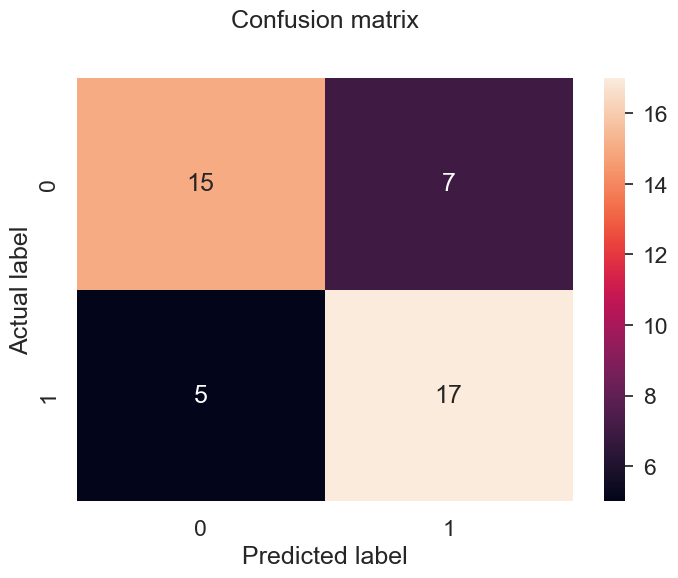

In [24]:
y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

#### Using eli5 library to analyse which are the most important features for our learned RF model

In [25]:
feature_names = X_train.columns.values
show_weights(rf, feature_names=feature_names)

Weight,Feature
0.2043 ± 0.2837,Area
0.1554 ± 0.2398,Shorline lenght
0.1438 ± 0.1813,Forests around the coasline
0.1120 ± 0.1529,Lake elongation index
0.1060 ± 0.1625,Coast development index
0.1018 ± 0.1694,Shorline overgrowth degree
0.0956 ± 0.1527,Mean depth
0.0811 ± 0.1450,Vegeation coverage of lake


#### Check variance in RF prediction quality

Scores mean=0.69 +/- 0.07 (1 s.d.)


Text(0, 0.5, 'Frequency')

<Figure size 800x550 with 0 Axes>

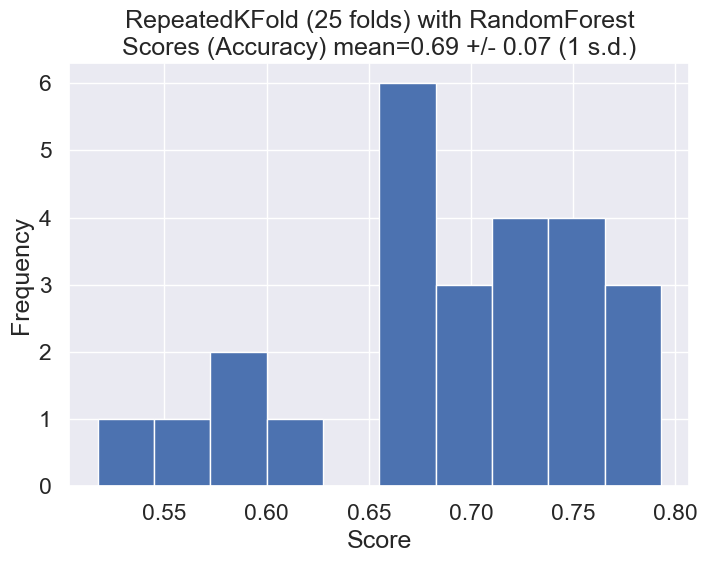

In [26]:
scores = cross_val_score(rf, X, Y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")

### Gradient boosting classifier

In [29]:
params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 5, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

Text(0, 0.5, 'Log Loss')

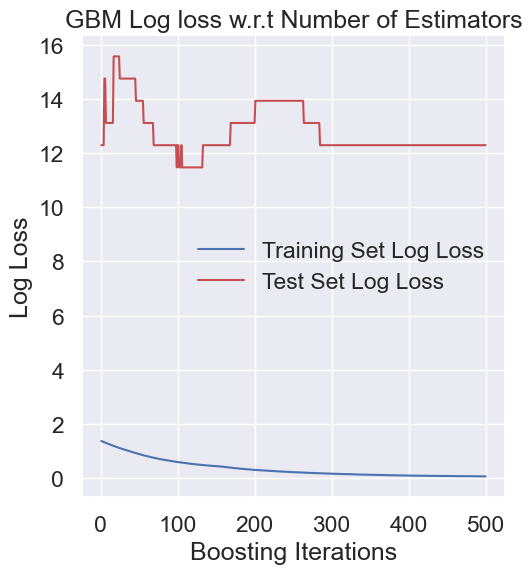

In [33]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = log_loss(y_test, y_pred, labels=np.unique(y_train))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM Log loss w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-', label='Training Set Log Loss')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Log Loss')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Log Loss')

In [34]:
params = {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, y_pred)
print("Accuracy of GBM Classifier: {0:0.2f}".format(gbm_score * 100.0))

Accuracy of GBM Classifier: 61.36


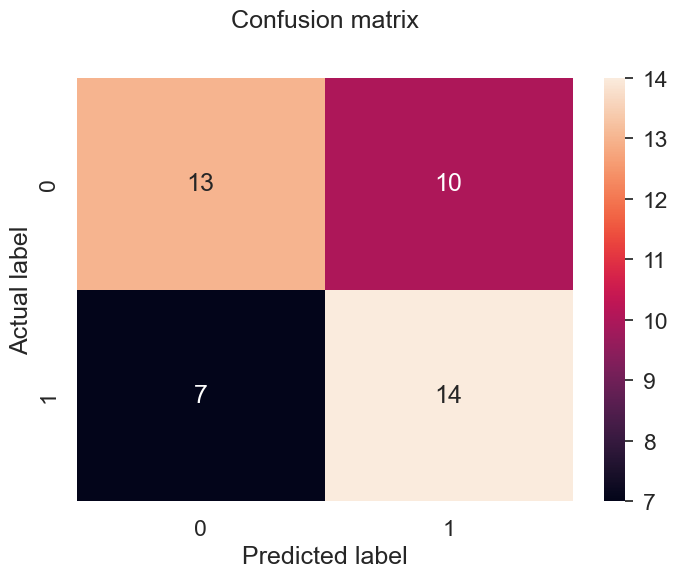

In [35]:
confusion_mat(y_pred, y_test)

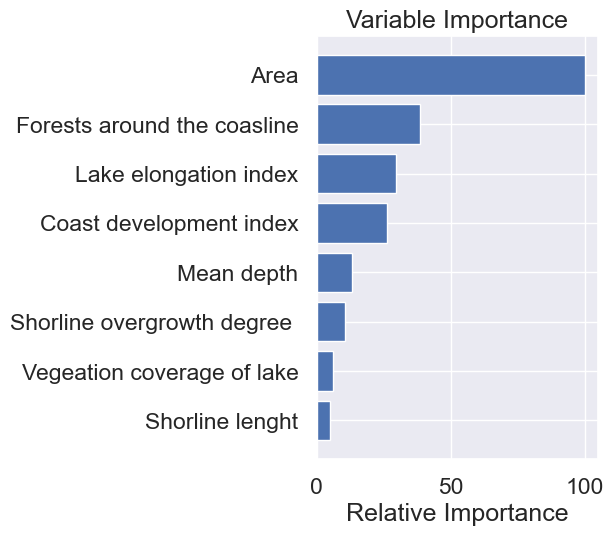

In [36]:
feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBoost

In [38]:
param = {
    'max_depth': 10,
    'eta': 0.8,
    'subsample': 1,
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'learning_rate': 0.001
}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [39]:
y_pred = xgb.predict(X_test)
xgb_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier: {0:0.2f}".format(xgb_score * 100.0))

Accuracy of XGB Classifier: 59.09


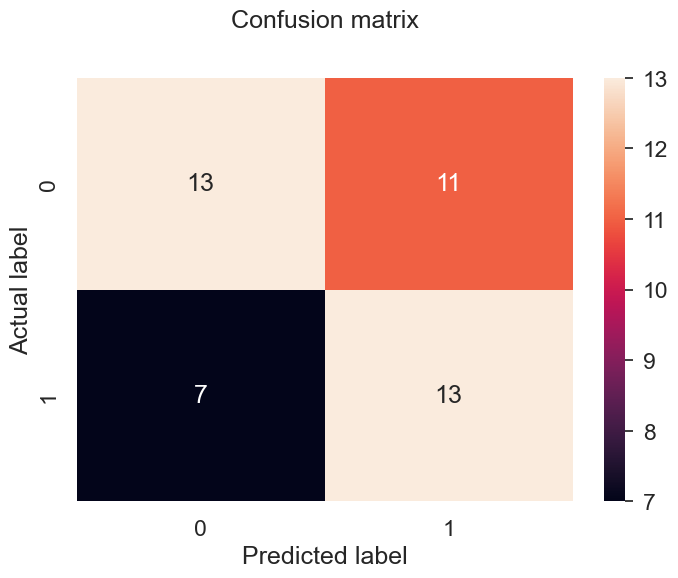

In [41]:
confusion_mat(y_pred, y_test)

<Figure size 800x550 with 0 Axes>

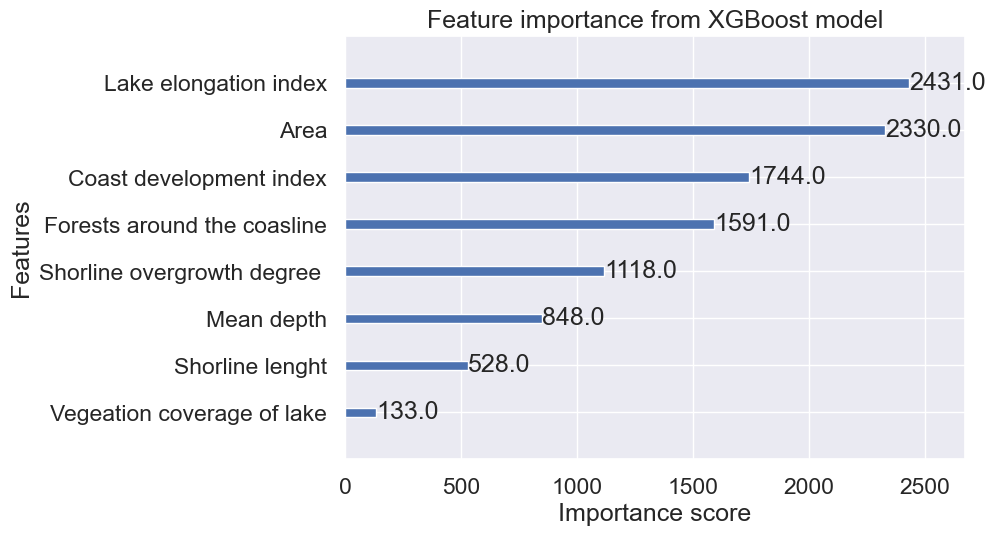

In [42]:
plt.figure()
plot_importance(xgb, title="Feature importance from XGBoost model")
plt.show()

## Explainability analysis

In [44]:
model = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.001)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [46]:
y_pred = model.predict(X_test)
model_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier {0:0.2f}".format(model_score * 100.0))

Accuracy of XGB Classifier 59.09


In [47]:
confusion_matrix(y_pred, y_test)

array([[13, 11],
       [ 7, 13]])

In [48]:
shap.initjs()

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

## 2 Lakes prefered in Tourism

In [50]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

In [54]:
i = 3
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

## 2 Lakes not prefered in Tourism

In [55]:
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

In [57]:
i = 7
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

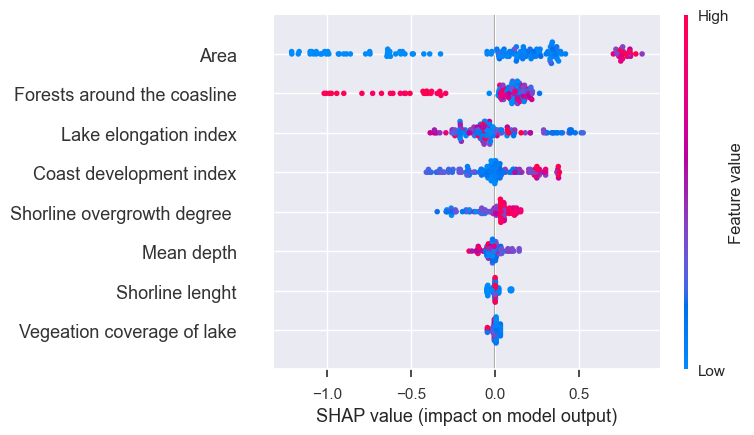

In [52]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False)
plt.show()

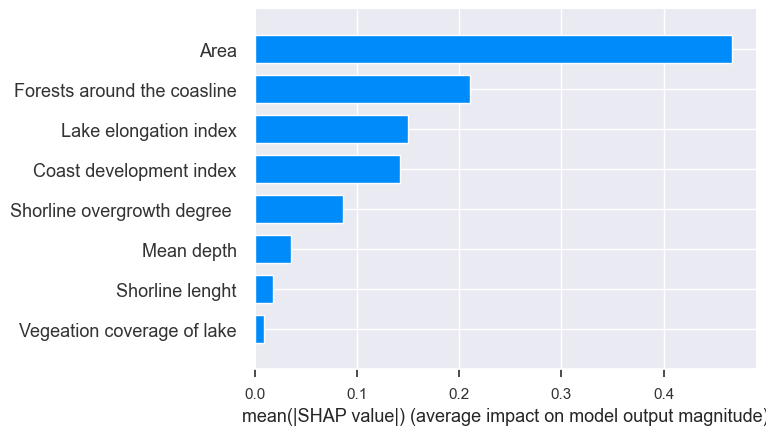

In [53]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False, plot_type='bar')
plt.show()

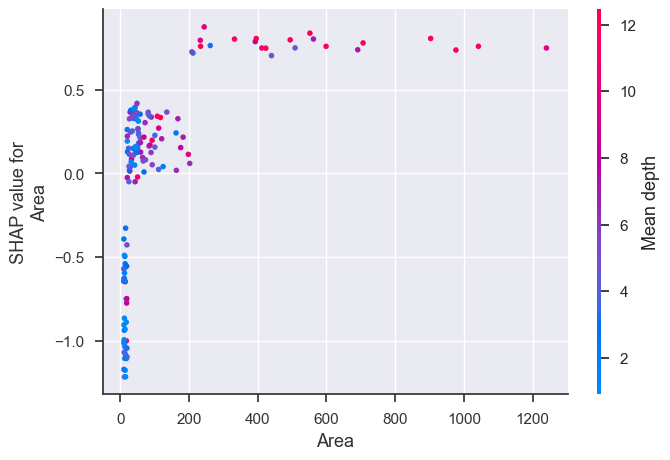

In [58]:
shap.dependence_plot("Area", shap_values, features=X, interaction_index="Mean depth")

In [59]:
shap.force_plot(explainer.expected_value, shap_values[:121, :], show=False, features=X.iloc[:121, :])

## Lake groups:
a)
   - big area

b)
   - big area
   - forest around coastline
   - high lake elongation index

c)
   - much forest around coastline